# Categorical NN Classifier

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import random
import subprocess
import timeit
import numpy as np
import scipy as sp
import sympy as sy
import pandas as pd
import itertools
import matplotlib.pyplot as plt

# Functions for sparse matrices
from functools import reduce
from scipy.sparse import csc_matrix, dok_matrix, kron

# Functions to play animations
from matplotlib import animation
from IPython.display import display

## Data Loading and Visualization

Data Source: http://www.ats.ucla.edu/

Load data

In [2]:
data = pd.read_csv('student_data.csv')
data.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


Plot data

In [3]:
def scatter(data, xaxis, yaxis):
    X = np.array(data[[xaxis, yaxis]])
    Y = np.array(data["admit"])
    admitted = X[np.argwhere(Y==1)]
    rejected = X[np.argwhere(Y==0)]
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'red', edgecolor = 'k')
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'cyan', edgecolor = 'k')
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)

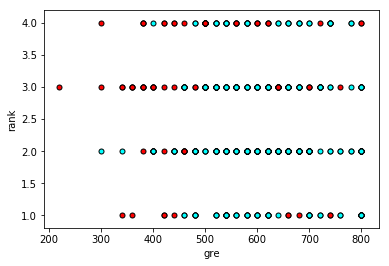

In [4]:
scatter(data[data["gpa"] > 2.5], xaxis = "gre", yaxis = "rank")
plt.show()

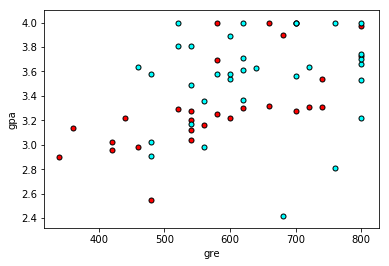

In [5]:
scatter(data[data["rank"] == 1], xaxis = "gre", yaxis = "gpa")
plt.show()

## Pre-Processing

To demonstrate multi-category classifcation, we one-hot encode the admission variable

Then normalize the input variables to be in the range (0, 1)

In [6]:
processed_data = pd.concat([data, pd.get_dummies(data['admit'], prefix='admit')], axis=1)
processed_data = processed_data.drop('admit', axis=1)

processed_data.loc[:,'gpa'] *= np.divide(1, 4.)
processed_data.loc[:,'rank'] *= np.divide(1, 4.)
processed_data.loc[:,'gre'] *= np.divide(1, 800.)

processed_data.head()

,gre,gpa,rank,admit_0,admit_1
0,0.475,0.9025,0.75,1,0
1,0.825,0.9175,0.75,0,1
2,1.000,1.0000,0.25,0,1
3,0.800,0.7975,1.00,0,1
4,0.650,0.7325,1.00,1,0


Split the data into a training and a testing set. The size of the testing set will be 10% of the total data.

In [7]:
sample = np.random.choice(processed_data.index, size=int(len(processed_data)*0.9), replace=False)
train_data, test_data = processed_data.iloc[sample], processed_data.drop(sample)

In [8]:
train_data.head()
test_data.head()

,gre,gpa,rank,admit_0,admit_1
386,0.925,0.9650,0.50,0,1
292,0.850,0.9250,0.50,1,0
235,0.775,0.7625,0.50,1,0
243,0.775,0.8050,0.50,1,0
149,0.925,0.8275,0.25,1,0


,gre,gpa,rank,admit_0,admit_1
6,0.700,0.7450,0.25,0,1
9,0.875,0.9800,0.50,1,0
12,0.950,1.0000,0.25,0,1
18,1.000,0.9375,0.50,1,0
30,0.675,0.9450,1.00,1,0


In [9]:
X, Y = train_data[train_data.columns[0:3]], train_data[train_data.columns[3:5]]
X_test, Y_test = test_data[train_data.columns[0:3]], test_data[train_data.columns[3:5]]

In [10]:
X.head()
Y.head()

,gre,gpa,rank
386,0.925,0.9650,0.50
292,0.850,0.9250,0.50
235,0.775,0.7625,0.50
243,0.775,0.8050,0.50
149,0.925,0.8275,0.25


,admit_0,admit_1
386,0,1
292,1,0
235,1,0
243,1,0
149,1,0


# Define Network

### Define Functions

Activation functions

In [11]:
def identity(X):
    return X

def sigmoid(X):
    return 1 / (1 + np.exp(-np.array(X)))

def relu(X):
    if type(X) == np.ndarray:
        return np.array([val if val>0 else 0.001 for val in X])
    else:
        if X>0:
            return X
        else:
            return 0.001

def softmax(X):
    exps = np.exp(X - np.max(X))
    return exps / np.sum(exps)

fdict={'identity':identity,
       'relu':relu,
       'sigmoid':sigmoid,
       'softmax':softmax}

Derivative functions

In [12]:
def dsigmoid(X):
    return sigmoid(X) * (1 - sigmoid(X))

def drelu(X):
    if type(X) == np.ndarray:
        return np.array([1 if val>0 else 0 for val in X])
    else:
        if X>0:
            return 1
        else:
            return 0

def dsoftmax(X):
    dsoft = np.empty((len(X), len(X)) )
    
    for i in range(len(X)):
        for j in range(len(X)):
            if i==j:
                dsoft[i][j] = softmax(X)[i]*(1 - softmax(X)[j])
            else:
                dsoft[i][j] = softmax(X)[i]*softmax(X)[j]
    return dsoft

dfdict={'identity':identity,
        'relu':drelu,
        'sigmoid':dsigmoid,
        'softmax':dsoftmax}

Error functions

In [13]:
def binary_crossentropy(y, output):
    error = -(1/len(y) )*(np.dot(y, np.log(output) ) + np.dot(1 - y, np.log(1 - output) ) )
    derror = -(1/len(y) )*(np.divide(y, output) - np.divide(1 - y, 1 - output) )
    return error, derror

In [14]:
np.random.seed(1234)

class network:
    def __init__(self, structure):
        self.Nnodes = [structure[i][1] for i in range(len(structure))]
        self.funcs = [fdict.get(struct[i][0]) for i in range(len(struct))]
        self.dfuncs = [dfdict.get(struct[i][0]) for i in range(len(struct))]
        self.runningloss = 0.0
        self.Nruns = 0
        
        self.weights = []
        weight = np.identity(self.Nnodes[0])
        bias = np.zeros((self.Nnodes[0], 1) )
        self.weights.append(np.concatenate((weight, bias), axis=1) )
        
        for i in range(1, len(self.Nnodes) ):
            weight = np.random.normal(scale=1 / self.Nnodes[i]**.5, \
                                      size=(self.Nnodes[i], self.Nnodes[i - 1]))
            bias = np.random.normal(scale=1 / self.Nnodes[i]**.5, \
                                    size=(self.Nnodes[i], 1))
#             weight = np.random.randn(self.Nnodes[i], self.Nnodes[i - 1])
#             bias = np.random.randn(self.Nnodes[i], 1)
            self.weights.append( np.concatenate((weight, bias), axis=1) )
            
        self.dweights = []
        for iweight in self.weights:
            self.dweights.append(np.zeros(iweight.shape) )
            
    def run(self, iX, iY, learnrate):
        inputs, outputs = [], []
        outlayer = iX
        
        for i in range(len(self.funcs) ):
            inlayer = np.dot(self.weights[i], np.append(outlayer, 1))
            outlayer = self.funcs[i](inlayer)
            inputs.append(inlayer)
            outputs.append(outlayer)
            
        loss, dloss = binary_crossentropy(iY, outputs[-1])

        dchain = np.sum(dloss*self.dfuncs[-1]( inputs[-1] ), axis = 0)
        dchain = dchain.reshape(len(dchain), 1)

        for i in reversed(range(len(self.dfuncs) - 1) ):
            dweight = learnrate*np.outer(dchain, outputs[i] )
            dbias = learnrate*dchain
            wgrad = np.concatenate((dweight, dbias), axis = 1) 
            self.dweights[i + 1] += wgrad
            
            dchain = np.sum(dchain*self.weights[i + 1][:,:-1], axis = 0)*self.dfuncs[i](inputs[i])
            dchain = dchain.reshape(len(dchain),1)

#         print(inputs[-1])
#         print(outputs[-1])
#         print(loss)
        self.runningloss += loss
        self.Nruns += 1
        
    def update(self, batchsize = 1):
        for i, idweight in enumerate(self.dweights):
            self.weights[i] = self.weights[i] - (1/batchsize)*idweight
            
        self.dweights.clear()
        
        for iweight in self.weights:
            self.dweights.append(np.zeros(iweight.shape) )
            
    def printloss(self):
        avgloss = self.runningloss/self.Nruns
        self.runningloss = 0.0
        self.Nruns = 0
        print("loss: ", avgloss)
        
    def evaluate(self, testX, testY):
        testloss = 0.0
        pos = []
        neg = []
      
        for iX, iY in zip(testX.values, testY.values):
            outlayer = iX
            
            for i, iweight in enumerate(self.weights):
                inlayer = np.dot(iweight, np.append(outlayer, 1))
                outlayer = self.funcs[i](inlayer)

            if int(iY[1]) - int(iY[0]) > 0:
                pos.append(outlayer[1] - outlayer[0])
            else:
                neg.append(outlayer[1] - outlayer[0])
                
            loss, dloss = binary_crossentropy(iY, outlayer)
            testloss += loss
        testloss = testloss/len(testX)
        
        print("test loss: ", testloss)
        
        bins = np.linspace(-1, 1, 30)
        print(len(pos), len(neg))

        plt.hist(np.array(pos), bins, alpha=0.5, label='admitted')
        plt.hist(np.array(neg), bins, alpha=0.5, label='rejected')
        plt.legend(loc='upper right')
        plt.show()
        
    def checkone(self, iX, iY):
        outlayer = iX

        for i, iweight in enumerate(self.weights):
            inlayer = np.dot(iweight, np.append(outlayer, 1))
            outlayer = self.funcs[i](inlayer)
            print("in", np.around(inlayer, 3) )
            print("out", np.around(outlayer, 3) )
        

In [15]:
NX, dimX = X.shape
NY, dimY = Y.shape

struct = [['identity', 3],
          ['relu', 10],
          ['relu', 10],
          ['relu', 10],
          ['softmax', 2]]

model = network(struct)

In [16]:
# Neural Network hyperparameters
epochs = 100
learnrate = 0.01
batchsize = 10
printevery = 1000

counter = 0
for e in range(epochs):
    
    for iX, iY in zip(X.values, Y.values):
        model.run(iX, iY, learnrate)
#         model.run(X.values[0], Y.values[0], learnrate)

        if counter%printevery == 0:
            model.printloss()
            
        if counter%batchsize == 0:
            model.update(batchsize)
            
        counter += 1

loss:  1.2527544027216102
loss:  0.6043840571559851
loss:  0.604700192939704
loss:  0.6065684651286417
loss:  0.6001015038469333
loss:  0.5924669999443721
loss:  0.5873707376981594
loss:  0.5979526443814892
loss:  0.5905590619501553
loss:  0.5880117147946955
loss:  0.5799285883567967
loss:  0.5844746038256035
loss:  0.5887581646789343
loss:  0.5837110790405581
loss:  0.5761324075291144
loss:  0.5734721191545061
loss:  0.5881449827358507
loss:  0.5813570288680554
loss:  0.5779789028472081
loss:  0.5715679955140532
loss:  0.5786866824654883
loss:  0.5842153417508227
loss:  0.5792280482754877
loss:  0.5713338795078481
loss:  0.5698416972888505
loss:  0.5862420298259241
loss:  0.579268068743395
loss:  0.575277980599392
loss:  0.5693390407914745
loss:  0.5774378589100189
loss:  0.5830684549984845
loss:  0.5778299707699185
loss:  0.5695894559350497
loss:  0.5684816088401176
loss:  0.5851905727403733
loss:  0.5780327563308773


test loss:  0.5762016518784694
111 249


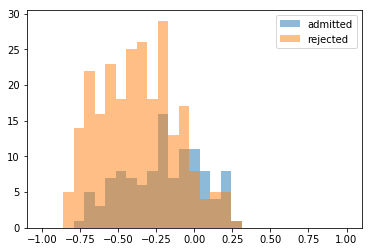

In [17]:
model.evaluate(X, Y)

## Calculating the Accuracy on the Test Data

In [18]:
# Calculate accuracy on test data
# test_out = sigmoid(np.dot(admitX_test, weights))
# predictions = test_out > 0.5
# accuracy = np.mean(predictions == admitY_test)
# print("Prediction accuracy: {:.3f}".format(accuracy))

In [19]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from collections import OrderedDict
from torch.utils.data import SubsetRandomSampler

torch.set_default_dtype(torch.float64)

In [20]:
tX = torch.from_numpy(X.values)
tY = torch.from_numpy(Y.values)
tX_test = torch.from_numpy(X_test.values)
tY_test = torch.from_numpy(Y_test.values)

# Build a feed-forward network
torchmodel = nn.Sequential(OrderedDict([('fc1', nn.Linear(dimX, 10)),
                                        ('relu1', nn.ReLU()),
                                        ('fc2', nn.Linear(10, 10)),
                                        ('relu2', nn.ReLU()),
                                        ('output', nn.Linear(10, dimY)),
                                        ('softmax', nn.Softmax(dim=1))]))
# Define the loss
criterion = nn.BCELoss()
optimizer = optim.SGD(torchmodel.parameters(), lr=0.003)

#print(torchmodel)

In [21]:
epochs = 100
batch_size = 1
print_every = 10
train_losses, test_losses = [], []

torchmodel.train()

for e in range(epochs):
    running_loss = 0    
        
    for iX, iY in zip(tX, tY):
        optimizer.zero_grad()
        
        iX = iX.view(1, iX.shape[0])
        iY = iY.view(1, iY.shape[0]).type(torch.DoubleTensor)
        output = torchmodel.forward(iX)
        loss = criterion(output, iY)
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            for iX, iY in zip(tX_test, tY_test):
                iX = iX.view(1, iX.shape[0])
                iY = iY.view(1, iY.shape[0]).type(torch.DoubleTensor)
                logps = torchmodel.forward(iX)
                test_loss += criterion(logps, iY)
                
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(2, dim=1)

                equals = top_class == iY.view(*top_class.shape).type(torch.LongTensor)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(X))
        test_losses.append(test_loss/len(X_test))

        if e%print_every == 0:
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(X)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(X_test)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(X_test)))

Sequential(
  (fc1): Linear(in_features=3, out_features=10, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=10, out_features=2, bias=True)
  (softmax): Softmax()
)

Epoch: 1/100..  Training Loss: 0.641..  Test Loss: 0.668..  Test Accuracy: 0.400
Epoch: 11/100..  Training Loss: 0.613..  Test Loss: 0.665..  Test Accuracy: 0.400
Epoch: 21/100..  Training Loss: 0.605..  Test Loss: 0.650..  Test Accuracy: 0.400
Epoch: 31/100..  Training Loss: 0.596..  Test Loss: 0.632..  Test Accuracy: 0.400
Epoch: 41/100..  Training Loss: 0.590..  Test Loss: 0.618..  Test Accuracy: 0.400
Epoch: 51/100..  Training Loss: 0.587..  Test Loss: 0.610..  Test Accuracy: 0.275
Epoch: 61/100..  Training Loss: 0.585..  Test Loss: 0.608..  Test Accuracy: 0.275
Epoch: 71/100..  Training Loss: 0.583..  Test Loss: 0.608..  Test Accuracy: 0.300
Epoch: 81/100..  Training Loss: 0.582..  Test Loss: 0.608..  Test Accuracy: 0.300
Epoch: 91/100..  Training Loss: 0.580..  Test Loss: 0.608..  Test Accuracy: 0.350
